In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from scipy.stats import pearsonr
from tqdm import tqdm
import timeit

Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.
SCORE goes from -3.89 to 2.73. 

- preprocess/index_to_protein_and_gene.txt

- preprocess/adjacence_matrix.txt

Genes:16,481  
Cell Lines:1,081  
Primary Diseases:31 (?)  
Lineages:28 (?)

## Retrieve data 

In [5]:
gene_expression = pd.read_csv('preprocess/gene_expression.csv').set_index('DepMap')
gene_effect = pd.read_csv('preprocess/gene_effect.csv').set_index('DepMap')

In [19]:
protein_info = pd.read_csv('preprocess/index_to_protein_and_gene.txt', header=None, sep=' ')
protein_info = protein_info.rename(columns={0:'index', 1:'protein', 2:'gene_ID'})
protein_info = protein_info.set_index('index')

In [35]:
adjacence_matrix = np.loadtxt('preprocess/adjacence_matrix.txt', delimiter=' ', dtype=int)

In [27]:
gene_expression.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,3.116032,0.056584,0.226509,0.111031,0.000000,1.035624,0.176323,5.700440,4.144046,0.790772,...,5.080658,6.675957,0.978196,1.914565,4.700994,3.282440,2.797013,6.821455,3.010780,4.381975
ACH-000002,1.395063,0.000000,0.275007,0.111031,0.000000,0.137504,0.000000,5.078951,1.948601,0.000000,...,3.204767,6.388017,0.097611,1.000000,3.925050,0.000000,1.070389,5.963474,2.169925,3.255501
ACH-000003,1.400538,4.305241,0.321928,0.150560,0.000000,4.219556,0.097611,5.195348,3.962549,1.687061,...,4.013462,7.528181,0.464668,1.555816,2.851999,0.704872,2.316146,7.302867,2.659925,2.748461
ACH-000004,4.178715,0.000000,0.214125,0.344828,0.070389,0.097611,0.000000,6.336819,3.231125,0.000000,...,4.276497,6.098664,0.765535,1.622930,3.619413,0.014355,2.032101,7.002252,3.444932,4.910733
ACH-000005,4.003602,0.014355,0.137504,0.014355,0.000000,0.028569,0.000000,6.337176,3.781360,0.000000,...,5.628482,6.785289,0.807355,1.773996,3.763412,0.014355,2.761285,6.826421,3.524816,5.592457


In [28]:
gene_effect.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


In [26]:
protein_info.head()

,protein,gene_ID
index,,
0,9606.ENSP00000263100,A1BG
1,9606.ENSP00000378868,A1CF
2,9606.ENSP00000323929,A2M
3,9606.ENSP00000299698,A2ML1
4,9606.ENSP00000475261,A3GALT2


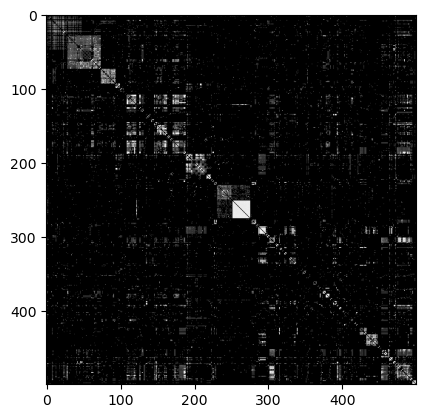

In [34]:
plt.imshow(adjacence_matrix[:500,:500], cmap='gray');plt.show()

## Smooth graph

For node $i$ with value $x_i$, we compute a new value $x_i^*$:
$$x_i^* = \lambda x_i 
+ (1-\lambda) \sum_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j$$
where 
$\lambda$ is a parametrization factor, 
$\mathcal N(i)$ is the set of neighbors of node $i$,
$e_{ji}$ is the weight of the edge from node $j$ to node $i$.



In [89]:
def smoothen(x, lamb, adjacence_matrix):
    new_x = x * 0
    for i in range(len(x)):  # rmk: can be written as a matrix product
        alphas = adjacence_matrix[i]
        new_x[i] = lamb * x[i] + (1-lamb) * alphas.dot(cl_expression) / np.sum(alphas)
    return new_x

### Compare lambda coefficient

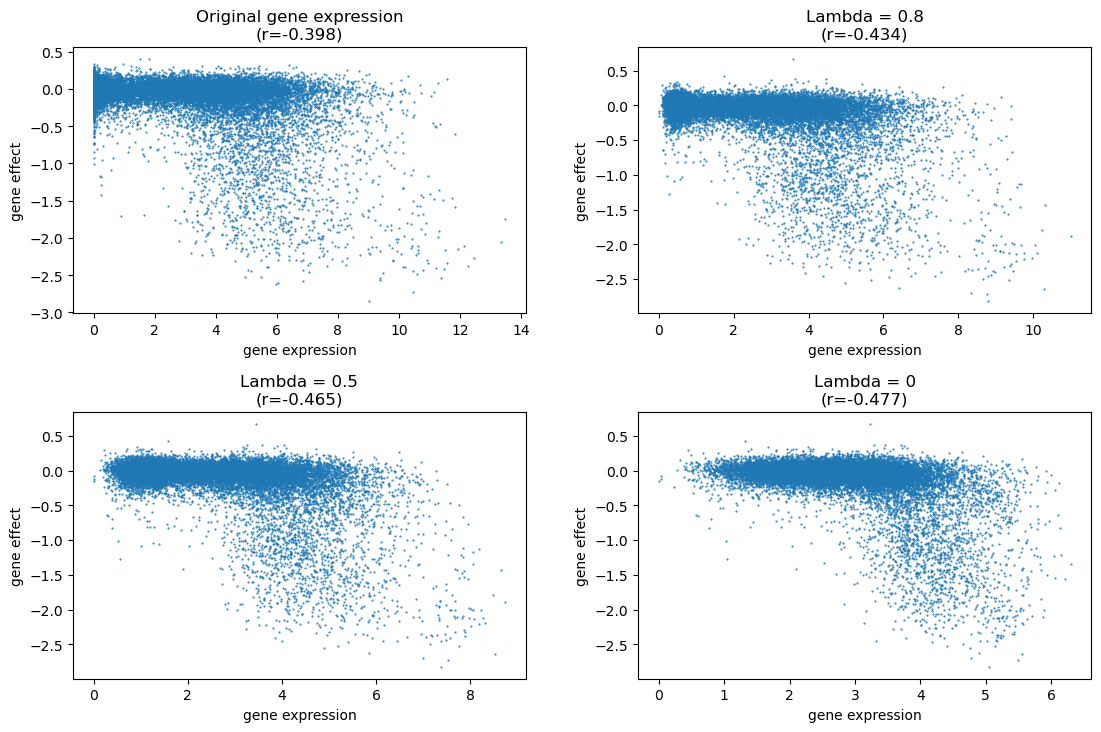

CPU times: user 30.1 s, sys: 979 ms, total: 31 s
Wall time: 17.8 s


In [154]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 2,2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()
pearson_coeff = pearsonr(gene_expression.iloc[cell_line], gene_effect.iloc[cell_line]).statistic
axs[0].scatter(gene_expression.iloc[cell_line], 
               gene_effect.iloc[cell_line], 
               marker='.', s=1)
axs[0].set_title(f'Original gene expression\n(r={pearson_coeff:.3f})')

lambs = [0.8, 0.5, 0]
cell_lines = [253]

for lamb_idx, lamb in enumerate(lambs):
    xx_expression = []
    yy_effect = []
    for cell_line in cell_lines:
        cl_expression = gene_expression.iloc[cell_line]
        new_cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)
        
        xx_expression.append(new_cl_expression)
        yy_effect.append(gene_effect.iloc[cell_line])
    
    xx = np.concatenate(xx_expression)
    yy = np.concatenate(yy_effect)
    
    pearson_coeff = pearsonr(xx, yy).statistic

    axs[lamb_idx+1].scatter(xx, yy, marker='.', s=1)
    axs[lamb_idx+1].set_title(f"Lambda = {lamb}\n(r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

### Compare successive smoothing

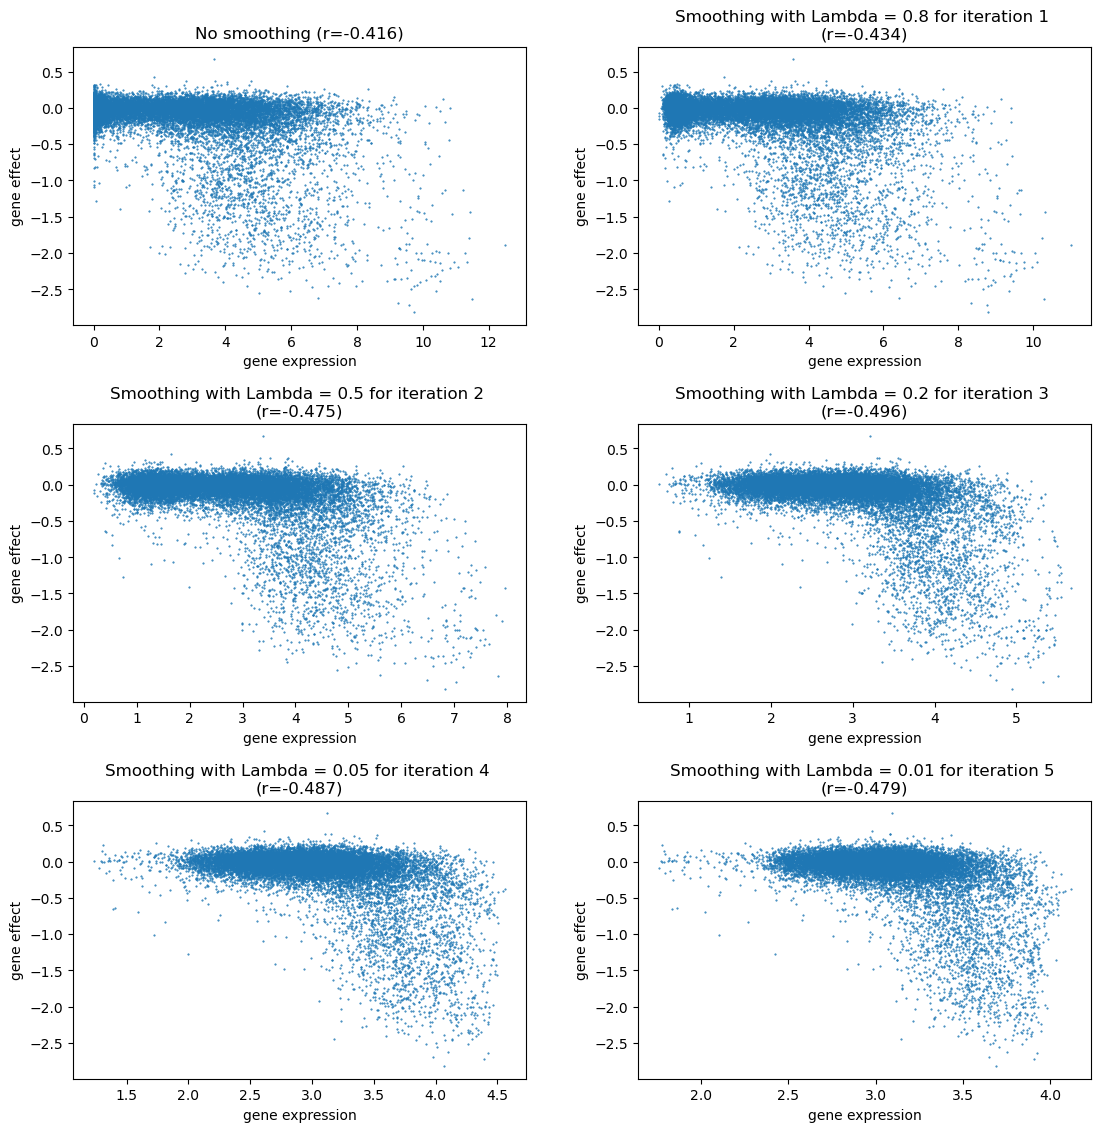

CPU times: user 29.5 s, sys: 707 ms, total: 30.2 s
Wall time: 19.3 s


In [126]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 3, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

#lambs = [0.5] * 3
lambs = [0.8, 0.5, 0.2, 0.05, 0.01]
cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No smoothing (r={pearson_coeff:.3f})')

for smoothing_idx in range(len(lambs)):
    lamb = lambs[smoothing_idx]
    cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    
    axs[smoothing_idx+1].scatter(cl_expression, 
                            gene_effect.iloc[cell_line], 
                            marker='.', s=1)
    #axs[smoothing_idx+1].set_title(f"Smoothing {smoothing_idx+1} times")
    axs[smoothing_idx+1].set_title(f"Smoothing with Lambda = {lamb} for iteration {smoothing_idx+1} "
                                   f"\n(r={pearson_coeff:.3f})")
    

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

### Other types of layer

We define 6 types of layers:

- Summation with normalization 
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \sum_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Summation without normalization 
$$x_i^* = \lambda_1 x_i + \lambda_2 \sum_{j \in \mathcal N(i)} e_{ji}  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Mean value with normalization 
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \frac 1 {|\mathcal N(i)|}\sum_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Mean value without normalization 
$$x_i^* = \lambda_1 x_i + \lambda_2 \frac 1 {|\mathcal N(i)|}\sum_{j \in \mathcal N(i)} e_{ji}  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Maximum value with normalization 
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \max_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Maximum value without normalization 
$$x_i^* = \lambda_1 x_i + \lambda_2 \max_{j \in \mathcal N(i)} e_{ji}  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$


In [103]:
def graphnn_layer(x, adjacence_matrix, params, aggr='sum', normalize=True, bias=None):
    new_x = x * 0
    
    if (type(params) is list or type(params) is tuple) and len(params) > 1:
        pass
    else:
        params = [params, 1 - params]
        
    for i in range(len(x)):  # rmk: can be written as a matrix product
        alphas = adjacence_matrix[i]
        norm_factor = np.sum(alphas) if normalize else 1
        if aggr == 'add':
            new_x[i] = params[0] * x[i] + params[1] * np.sum(alphas * cl_expression) / norm_factor
        elif aggr == 'mean':
            nb_neighbors = np.sum(alphas > 0)
            new_x[i] = params[0] * x[i] + params[1] * np.sum(alphas * cl_expression) / (norm_factor * nb_neighbors)
        elif aggr == 'max':
            new_x[i] = params[0] * x[i] + params[1] * np.max(alphas * cl_expression) / (norm_factor)
    
    if bias is not None:
        new_x += bias
        
    return new_x

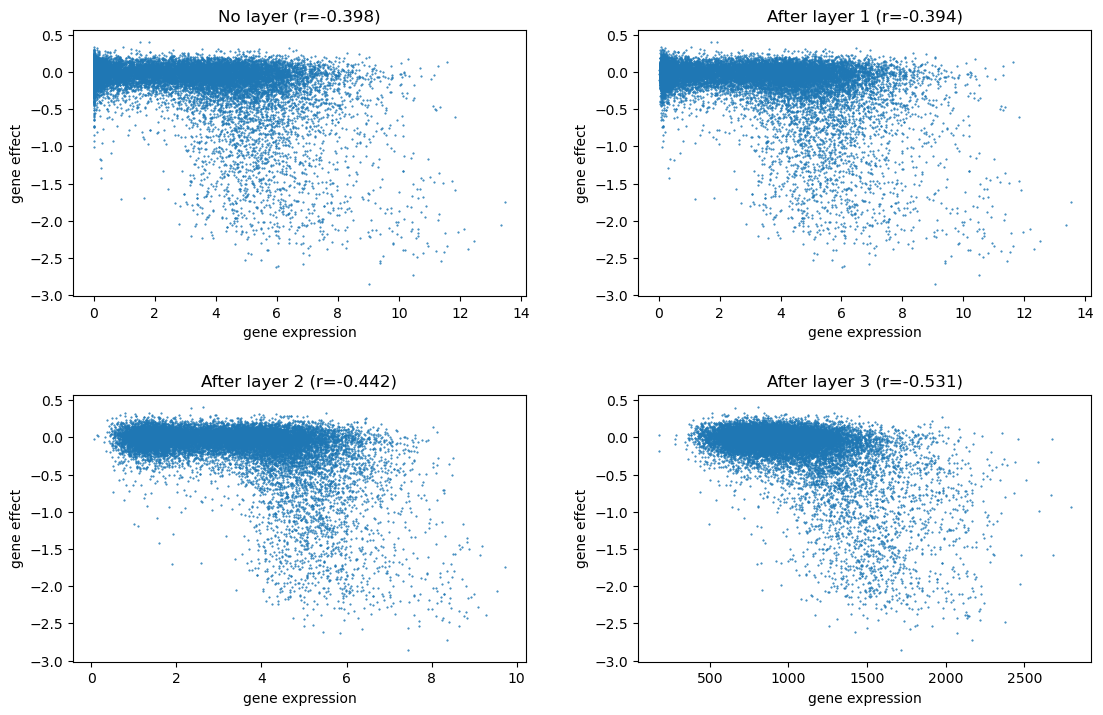

CPU times: user 30.4 s, sys: 632 ms, total: 31 s
Wall time: 33 s


In [116]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 2, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

layers = [
    {'params':0.5, 'aggr':'add'},
    {'params':[1, 0.2], 'aggr':'max'},
    {'params':[0.9, 0.1], 'aggr':'mean', 'normalize':False, 'bias':0.1}
]
layers = [
    {'params':[1,2], 'aggr':'max'},
    {'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2}
]
cell_line = 0
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    lamb = lambs[smoothing_idx]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)

    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

0 -0.4127546455075015
1 -0.4616088127482467
2 -0.5454837776751289


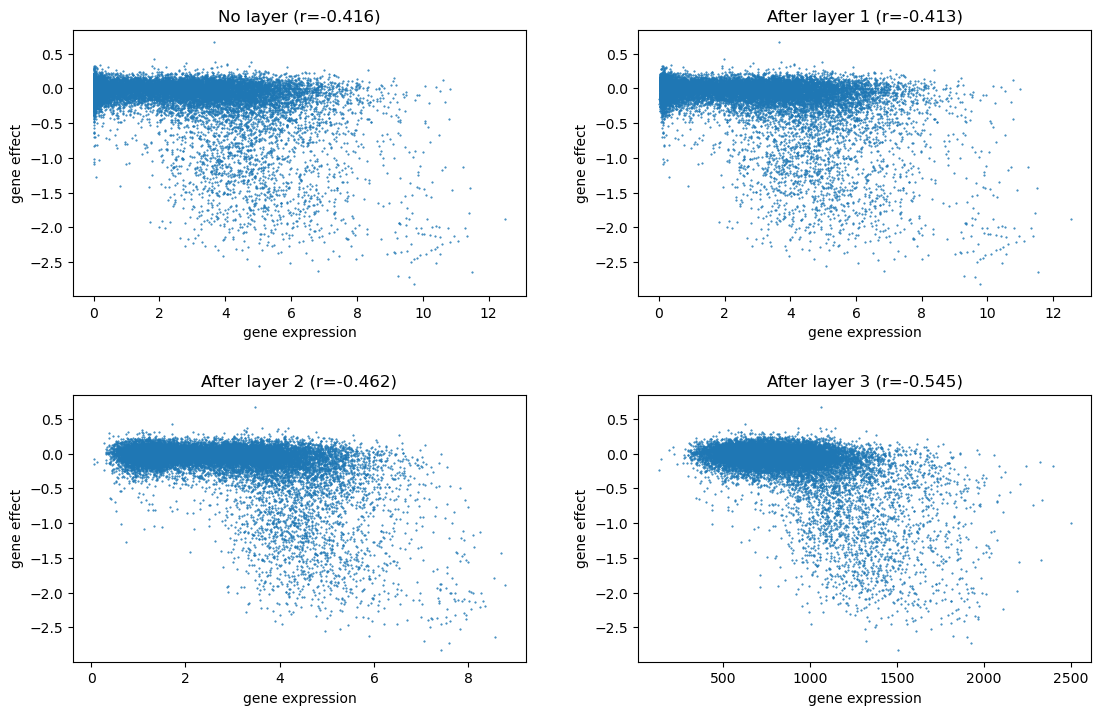

CPU times: user 29.3 s, sys: 765 ms, total: 30.1 s
Wall time: 30.3 s


In [124]:
%%time
fig_width = 6
fig_height = 4

layers = [
    {'params':[1,2], 'aggr':'max'},
    {'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2},
]

nb_i, nb_j = len(layers)//2+1, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    lamb = lambs[smoothing_idx]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(i,pearson_coeff)
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

0 -0.5430359824213266


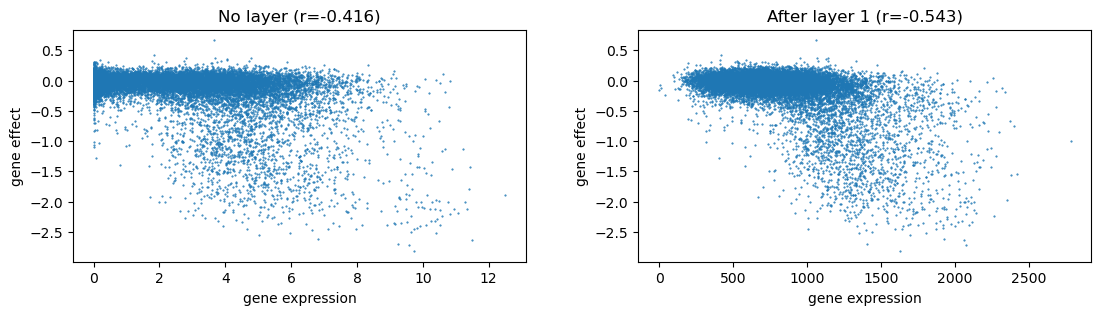

CPU times: user 13.3 s, sys: 203 ms, total: 13.5 s
Wall time: 13.3 s


In [138]:
%%time
fig_width = 6
fig_height = 4

layers = [
    #{'params':[1,2], 'aggr':'max'},
    #{'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2},
]

nb_i, nb_j = len(layers)//2+1, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    lamb = lambs[smoothing_idx]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(i,pearson_coeff)
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

### Effect of Lambda on smoothing

In [149]:
%%time
lambs = [0.01, 0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.25, 0.3, 0.5, 0.8, 1]
cell_line = 253

smooth_pearson_coeffs = []
for lamb in lambs:
    cl_expression = gene_expression.iloc[cell_line]
    cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    smooth_pearson_coeffs.append(pearson_coeff)

CPU times: user 1min 34s, sys: 1.56 s, total: 1min 36s
Wall time: 49.8 s


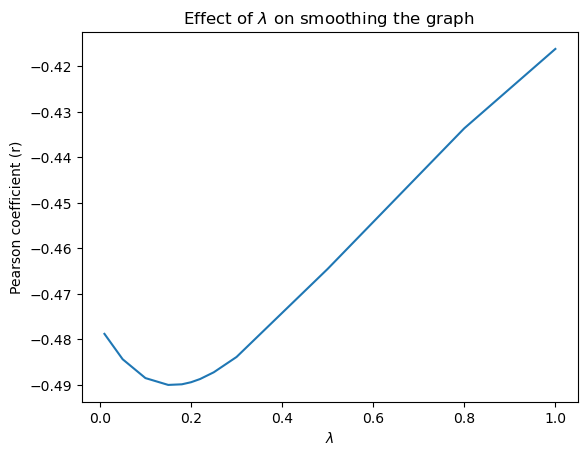

In [151]:
plt.plot(lambs, smooth_pearson_coeffs)
plt.xlabel("$\lambda$")
plt.ylabel("Pearson coefficient (r)")
plt.title('Effect of $\lambda$ on smoothing the graph ')
plt.show()

### Effect of lambda on mean value layer

In [155]:
%%time
#lambs = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1]
lambs = [0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

cell_line = 253

pearson_coeffs = []
for lamb in lambs:
    #layer = {'params':lamb, 'aggr':'max'}
    layer = {'params':lamb, 'aggr':'mean', 'normalize':False}
    cl_expression = gene_expression.iloc[cell_line]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(lamb, pearson_coeff)
    pearson_coeffs.append(pearson_coeff)

0.9 -0.5445066613358953
0.95 -0.5459507090995303
0.96 -0.5462757569814944
0.97 -0.5463360368529615
0.98 -0.5450671247856217
0.99 -0.5355847800158756
CPU times: user 1min 19s, sys: 2.23 s, total: 1min 22s
Wall time: 1min 27s


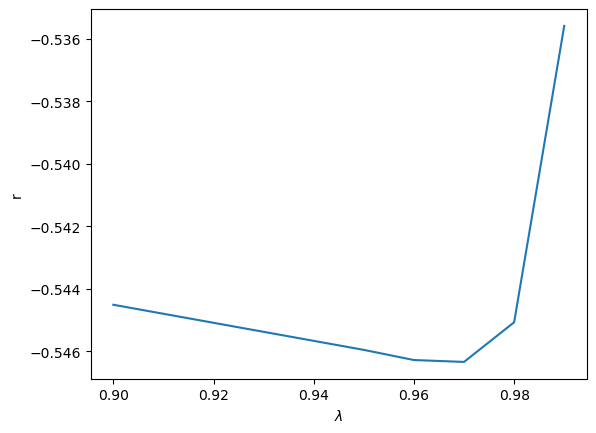

In [156]:
plt.plot(lambs[:], pearson_coeffs[:])
plt.xlabel("$\lambda$")
plt.ylabel("r")
plt.show()

In [ ]:
%%time
fig_width = 6
fig_height = 4

layers = [
    {'params':0.16, 'aggr':'add'},
    {'params':0.97, 'aggr':'mean', 'normalize':False},
]

nb_i, nb_j = len(layers)//2+1, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    lamb = lambs[smoothing_idx]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(i,pearson_coeff)
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()